In [1]:
%matplotlib inline

import os
import os.path
import glob
import random
import copy
import math
import scipy.io
import pickle

import shutil
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from __future__ import print_function
from time import time, sleep
from scipy import misc
from sklearn.neighbors import NearestNeighbors

from skimage.io import imread
from skimage.io import imshow
from skimage.io import imsave
from skimage.transform import rescale

from torchvision import transforms
from torchvision.models import vgg19
from torchvision.models.vgg import model_urls
from torch.utils.serialization import load_lua
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import LBFGS

# from IPython import display
# from IPython.display import clear_output
from PIL import Image

In [2]:
print(os.environ['CUDA_VISIBLE_DEVICES'])

1


In [3]:
import network

In [4]:
import cv2

In [5]:
import networks_cg

In [6]:
import matplotlib as mpl

## Options

In [7]:
opt_s_image_file = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/vkitti/lists/vkitti_rgb_all.txt'
opt_s_depth_file = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/vkitti/lists/vkitti_depth_all.txt'

In [8]:
opt_r_image_file = '/nfs/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/kitti/eigen-test/new/lists/eigen_rgb_test.txt'
opt_r_depth_file = '/nfs/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/kitti/eigen-test/new/lists/eigen_depth_test.txt'
opt_r_depth_interp_file = '/nfs/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/kitti/eigen-test/new/lists/eigen_depth_interp_test.txt'

## Utils

In [9]:
def imsave_colormap(image, imname, colormap='jet'):
    """
    image -- numpy array from [0,1]
    imname -- string (filename to save result)
    colormap -- string (name of the colormap to save)
    """
    cm = mpl.cm.get_cmap(colormap)
    im = np.zeros(image.shape)
    im = cm(image)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)
    im.save(imname)

In [10]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

## Prepare data

### Synthetic

In [11]:
img_transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# depth_transform = transforms.Compose([transforms.ToTensor(), 
#                                     transforms.Normalize([0.091], [0.246])])

In [12]:
opt_s_image_list = open(opt_s_image_file, 'r')
opt_s_depth_list = open(opt_s_depth_file, 'r')
s_filenames_img = []
s_filenames_dpt = []

for line in opt_s_image_list:
    s_filenames_img.append(line[:-1])
    
    depth_line = opt_s_depth_list.readline()
    s_filenames_dpt.append(depth_line[:-1])                       
    
opt_s_image_list.close()
opt_s_depth_list.close()

In [13]:
s_filenames_img[0]

'/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/vkitti/vkitti_1.3.1_rgb/0001/15-deg-left/00000.png'

In [14]:
s_filenames_dpt[0]

'/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/vkitti/vkitti_1.3.1_depthgt/0001/15-deg-left/00000.png'

In [15]:
print(len(s_filenames_img), len(s_filenames_dpt))

21260 21260


### Realistic

In [16]:
opt_r_image_list = open(opt_r_image_file, 'r')
opt_r_depth_list = open(opt_r_depth_file, 'r')
opt_r_depth_interp_list = open(opt_r_depth_interp_file, 'r')
r_filenames_img = []
r_filenames_dpt = []
r_filenames_dpt_interp = []

for line in opt_r_image_list:
    r_filenames_img.append(line[:-1])
    
    depth_line = opt_r_depth_list.readline()
    r_filenames_dpt.append(depth_line[:-1])
    
    depth_line_interp = opt_r_depth_interp_list.readline()
    r_filenames_dpt_interp.append(depth_line_interp[:-1])
    
#     image = Image.open(line[:-1]).convert('RGB')
#     image = img_transform (image)
    
#     
     
#     depth = cv2.imread(depth_line[:-1], cv2.IMREAD_UNCHANGED)
#     depth[depth > 473.57] = 473.57
#     depth = (depth / 473.57)*255.0
#     depth = Image.fromarray(depth.astype(np.uint8))
#     depth = depth.convert('L')
#     depth = depth_transform(depth)
    
opt_r_image_list.close()
opt_r_depth_list.close()

In [17]:
print(len(r_filenames_img), len(r_filenames_dpt))

697 697


### Load depth net

In [18]:
# depth_model_path_00 = '/media/hpc-4_Raid/dsungatullina/submission/pytorch-commutative/init_models/latest_net_img2task.pth'

In [19]:
#depth_model_path_00 = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/vkitti_base.pth'

In [20]:
model_name = 'vkitti_base_fair_smooth_80'

In [21]:
depth_model_path_00 = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/' + model_name + '/latest_net_Depth.pth'

In [22]:
# supervised synthetic depth
netG_C_00 = network.define_G(3, 1, 64, 4, 'batch', 'PReLU', 'UNet', 'kaiming', 0,  False, [0], 0.1)

netG_C_00.load_state_dict(torch.load(depth_model_path_00), strict=False)
print('Depth net Loaded')
netG_C_00 = netG_C_00.cuda()

_UNetGenerator(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
  )
  (conv2): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
  )
  (conv3): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

In [23]:
# model_name = 'vkitti_base_fair_smooth_80'
# depth_model_path_01 = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/' + model_name + '/latest_net_Depth.pth'

In [24]:
model_name = 'tmp'
depth_model_path_01 = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/' + 'vkitti_base_fair.pth'

In [25]:
# supervised synthetic depth
netG_C_01 = network.define_G(3, 1, 64, 4, 'batch', 'PReLU', 'UNet', 'kaiming', 0,  False, [0], 0.1)

netG_C_01.load_state_dict(torch.load(depth_model_path_01), strict=False)
print('Depth net Loaded')
netG_C_01 = netG_C_01.cuda()

_UNetGenerator(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
  )
  (conv2): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
  )
  (conv3): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

In [26]:
# # trans syn
# net_R2S = networks_cg.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
#                                       False, 'normal', 0.02, [0])

# model_path = '/media/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/' + model_name + '/latest_net_R2S.pth'

# if isinstance(net_R2S, torch.nn.DataParallel):
#     print('yes')
#     net_R2S = net_R2S.module
# state_dict = torch.load(model_path)
# if hasattr(state_dict, '_metadata'):
#     del state_dict._metadata
# net_R2S.load_state_dict(state_dict)
# print('Generator Loaded')

### Calculate metrics

In [27]:
save_path = '/media/hpc-4_Raid/dsungatullina/submission/results/26.04.19/' + model_name + '/'

if not os.path.exists(save_path):
    os.mkdir(save_path)
    
if not os.path.exists(save_path + 'images/'):
    os.mkdir(save_path + 'images/')
    
if not os.path.exists(save_path + 'figures/'):
    os.mkdir(save_path + 'figures/')

In [73]:
# rmse_log_sum = 0.0
# rmse_sum = 0.0
# sqr_relative_sum = 0.0
# abs_relative_sum = 0.0
# accuracy_sum = 0.0

# # baseline
# rmse_log_sum_ss = 0.0
# rmse_sum_ss = 0.0
# sqr_relative_sum_ss = 0.0
# abs_relative_sum_ss = 0.0
# accuracy_sum_ss = 0.0

cols, rows = 2, 2

# th = 1.25**3

min_depth = 1e-3
max_depth = 50.0

garg_crop = True
eigen_crop = False

num_samples = len(r_filenames_img)

rms     = np.zeros(num_samples, np.float32)
log_rms = np.zeros(num_samples, np.float32)
abs_rel = np.zeros(num_samples, np.float32)
sq_rel  = np.zeros(num_samples, np.float32)
d1_all  = np.zeros(num_samples, np.float32)
a1      = np.zeros(num_samples, np.float32)
a2      = np.zeros(num_samples, np.float32)
a3      = np.zeros(num_samples, np.float32)

for i in range(num_samples):
    
    img = Image.open(r_filenames_img[i]).convert('RGB')
    img = img.resize((640,192), resample=Image.LANCZOS)
    image = img_transform(img).unsqueeze(0) # torch tensor 1x3xhxw from [-1,1]
    
    depth = Image.open(r_filenames_dpt[i])
    depth = depth.resize((640,192), resample=Image.NEAREST)
    depth = np.array(depth)
#     depth[depth > max_depth] = max_depth
#     depth[depth < min_depth] = min_depth
    
    depth_i = Image.open(r_filenames_dpt_interp[i])
    depth_i = depth_i.resize((640,192), resample=Image.LANCZOS)
    depth_i = np.array(depth_i)
#     depth_i[depth_i > max_depth] = max_depth
#     depth_i[depth_i < min_depth] = min_depth
    
    fake_depth_00 = netG_C_00(image.cuda())
    fake_depth_00 = fake_depth_00[4]
    fake_depth_00 = (fake_depth_00 + 1.0) / 2.0
    fake_depth_00 = fake_depth_00 * 255.
#     fake_depth_00[fake_depth_00 > max_depth] = max_depth
    fake_depth_00[fake_depth_00 < min_depth] = min_depth

    
    fake_depth_01 = netG_C_01(image.cuda())
    fake_depth_01 = fake_depth_01[4]
    fake_depth_01 = (fake_depth_01 + 1.0) / 2.0
    fake_depth_01 = fake_depth_01 * 255.
#     fake_depth_01[fake_depth_01 > max_depth] = max_depth
    fake_depth_01[fake_depth_01 < min_depth] = min_depth
        
    
    ar_fake_depth_00 = fake_depth_00.squeeze(0).squeeze(0).cpu().detach().numpy() # numpy array
    ar_fake_depth_01 = fake_depth_01.squeeze(0).squeeze(0).cpu().detach().numpy() # numpy array
    
    # crop
    gt_depth = depth
    pred_depth = ar_fake_depth_00
    mask = np.logical_and(gt_depth > min_depth, gt_depth < max_depth)
#    mask = np.logical_and(mask, pred_depth > 1e-3)
#    mask = np.logical_and(mask, pred_depth <= max_depth)
    
    if garg_crop or eigen_crop:
        gt_height, gt_width = gt_depth.shape

        # crop used by Garg ECCV16
        # if used on gt_size 370x1224 produces a crop of [-218, -3, 44, 1180]
        if garg_crop:
            crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                             0.03594771 * gt_width,   0.96405229 * gt_width])
            crop = (np.around(crop)).astype(np.int32)
        # crop we found by trial and error to reproduce Eigen NIPS14 results
        elif eigen_crop:
            crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,   
                             0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

        crop_mask = np.zeros(mask.shape)
        crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
        mask = np.logical_and(mask, crop_mask)
    
    #print(type(gt_depth[mask]), gt_depth[mask].shape[0])
#     pred_depth = np.ones(gt_depth[mask].shape[0])*26.3850838474
#     abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth)

    abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])
    
    if False: # (i % 50 == 0)
        fig=plt.figure(figsize=(20, 10))
        print('Figure {}'.format(i))
        print('                           image                                                   groundtruth depth')
    
        fig.add_subplot(rows, cols, 1)
        plt.imshow(np.array(img))
        plt.axis('off')
        
        fig.add_subplot(rows, cols, 2)
        plt.imshow(depth_i, vmax=50)
        plt.axis('off')
        

        img.save(save_path + 'images/' + 'img_{}.png'.format(i))
        
#         fake_img = net_R2S(image.cuda())
#         fake_img = (fake_img + 1.0) / 2 * 255.
#         ar_fake_img = fake_img.squeeze(0).cpu().detach().numpy()
#         ar_fake_img = np.transpose(ar_fake_img, (1, 2, 0))
#         fake_img = Image.fromarray(ar_fake_img.astype(np.uint8))
#         fake_img.save(save_path + 'images/' + 'fake_img_{}.png'.format(i))
        
        imsave_colormap(depth_i*5/255., save_path + 'images/' + 'gt_{}.png'.format(i))
        imsave_colormap(ar_fake_depth_00*5/255., save_path + 'images/' + 'pred_{}.png'.format(i))
        
        fig.add_subplot(rows, cols, 3)
        plt.imshow(ar_fake_depth_00,  vmax=50)
        plt.axis('off')
        
        fig.add_subplot(rows, cols, 4)
        plt.imshow(ar_fake_depth_01,  vmax=50)
        plt.axis('off')
        
        plt.savefig(save_path + 'figures/' + '{}.png'.format(i))
        
        plt.show()
        
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), a1.mean(), a2.mean(), a3.mean()))

   abs_rel,     sq_rel,        rms,    log_rms,         a1,         a2,         a3
    0.4216,     6.4548,      8.602,      0.533,      0.364,      0.701,      0.853


AbsRel    SqRel    RMSE    RMSElog    δ<1.25    δ<1.252    δ<1.253
0.278     3.216    6.268   0.322      0.681     0.854      0.929    # Our fT , all-synthetic 
0.521     11.024   10.598  0.473      0.638     0.755      0.835    # Baseline, train set mean vK(I+D)

0.3730    4.3209   7.247   0.621      0.487     0.776      0.879    # w/o smoothness, gt clamped to
                                                                    # (0,50) during the training
0.4216    6.4548   8.602   0.533      0.364     0.701      0.853    # with smoothness, gt clamped to
                                                                    # (0,80) during the training

In [29]:
pwd

u'/nfs/hpc-4_Raid/dsungatullina/submission/pytorch-commutative/model'

In [18]:
import networks_cg

In [187]:
model_name = 'kitti_l1-50.0_com-r-10.0_com-s-0.0_cycle-1.0_lr-1e-5'
epoch = '1'

In [188]:
# trans syn
net_R2S = networks_cg.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                                      False, 'normal', 0.02, [0])

model_path = '/nfs/hpc-4_Raid/dsungatullina/submission/vkitti-kitti/models/' + model_name + '/' + epoch + '_net_S2R.pth'

if isinstance(net_R2S, torch.nn.DataParallel):
    print('yes')
    net_R2S = net_R2S.module
state_dict = torch.load(model_path)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
net_R2S.load_state_dict(state_dict)
print('Generator Loaded')

initialize network with normal
yes
Generator Loaded


In [189]:
save_path = '/media/hpc-4_Raid/dsungatullina/submission/results/30.04.19/cyclegan/' + model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)

save_path = save_path + '/' + epoch

if not os.path.exists(save_path):
    os.mkdir(save_path)

save_path_input = save_path + '/input/'
save_path_result = save_path + '/result/'

if not os.path.exists(save_path_input):
    os.mkdir(save_path_input)
    
if not os.path.exists(save_path_result):
    os.mkdir(save_path_result)

0


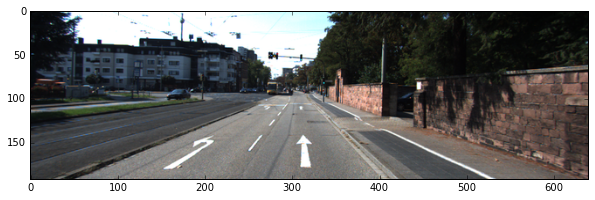

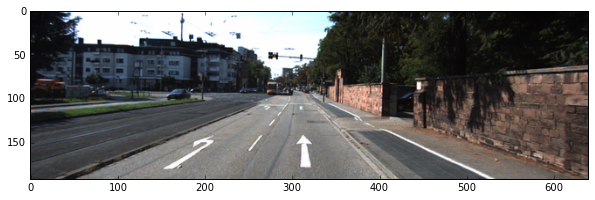

IOError: [Errno 2] No such file or directory: '/media/hpc-4_Raid/dsungatullina/submission/results/30.04.19/cyclegan/kitti_l1-50.0_com-r-10.0_com-s-0.0_cycle-1.0_lr-1e-5/1/input/0.png'

In [191]:
num_samples = len(r_filenames_img)

for i in range(num_samples):
    
    img = Image.open(r_filenames_img[i]).convert('RGB')
    img = img.resize((640,192), resample=Image.LANCZOS)
    image = img_transform(img).unsqueeze(0) # torch tensor 1x3xhxw from [-1,1]
    
    fake = net_R2S(image.cuda())
    fake = (fake + 1.0) / 2.0
    #fake = fake * 255.
    
    ar_fake = fake.squeeze(0).cpu().detach().numpy() # numpy array
    ar_fake = np.transpose(ar_fake, (1, 2, 0))
    
    if (i % 100 == 0) & (i < 2000):
        print(i)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(img))
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(ar_fake)
        plt.show()
        
        img.save(save_path_input + '{}.png'.format(i))
        ar_fake = ar_fake * 255
        fake = Image.fromarray(ar_fake.astype(np.uint8))
        fake.save(save_path_result + '{}.png'.format(i))
        
    if i > 2000:
        break


In [ ]:
# trans mod syn
netTrans_mod_syn = networks.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                                      False, 'normal', 0.02, [0])

model_path = '/media/hpc4_Raid/dsungatullina/autumn2018/pytorch-CycleGAN-and-pix2pix/checkpoints/full_framework/latest_net_G_A2B.pth'

if isinstance(netTrans_mod_syn, torch.nn.DataParallel):
    print('yes')
    netTrans_mod_syn = netTrans_mod_syn.module
state_dict = torch.load(model_path)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
netTrans_mod_syn.load_state_dict(state_dict)
print('Generator Loaded')

In [ ]:
# trans
netTrans = networks.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                                      False, 'normal', 0.02, [0])

model_path = '/media/hpc4_Raid/dsungatullina/autumn2018/pytorch-CycleGAN-and-pix2pix/checkpoints/syn2real_cyclegan-2/1_net_G_B.pth'

if isinstance(netTrans, torch.nn.DataParallel):
    print('yes')
    netTrans = netTrans.module
state_dict = torch.load(model_path)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
netTrans.load_state_dict(state_dict)
print('Generator Loaded')

In [ ]:
# trans mod
netTrans_mod = networks.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                                      False, 'normal', 0.02, [0])

model_path = '/media/hpc4_Raid/dsungatullina/autumn2018/pytorch-CycleGAN-and-pix2pix/checkpoints/full_framework/latest_net_G_B2A.pth'

if isinstance(netTrans_mod, torch.nn.DataParallel):
    print('yes')
    netTrans_mod = netTrans_mod.module
state_dict = torch.load(model_path)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
netTrans_mod.load_state_dict(state_dict)
print('Generator Loaded')

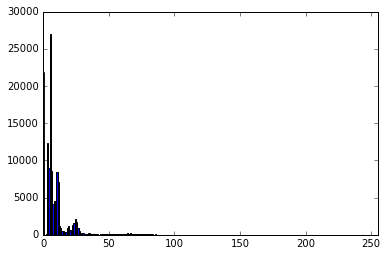

In [223]:
import matplotlib.pyplot as plt
import cv2

im = cv2.imread('image.jpg')
# calculate mean value from RGB channels and flatten to 1D array
vals = im.mean(axis=2).flatten()
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals, 255)
plt.xlim([0,255])
plt.show()

In [ ]:
        if garg_crop:
            crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                             0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)
        # crop we found by trial and error to reproduce Eigen NIPS14 results
        elif eigen_crop:
            crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,   
                             0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

In [226]:
img = Image.open(r_filenames_img[0])

In [227]:
img_a = np.array(img)

In [274]:
gt_height = 370
gt_width = 1224
crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                 0.03594771 * gt_width,   0.96405229 * gt_width])
print(crop)

[ 151.0000007   366.9999993    43.99999704 1180.00000296]


In [276]:
(np.around(crop)).astype(np.int32)

array([ 151,  367,   44, 1180], dtype=int32)

In [235]:
gt_height = 370
gt_width = 1224
crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                 0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

In [236]:
crop

array([ 151,  366,   43, 1180], dtype=int32)

In [233]:
crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,   
                0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

In [234]:
crop

array([ 122,  337,   43, 1180], dtype=int32)

In [230]:
mask = np.zeros((370, 1224))

In [231]:
mask[151:366, 43:1180] = 1

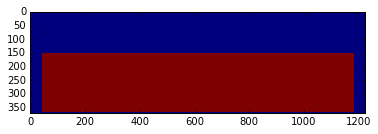

In [232]:
plt.imshow(mask)
plt.show()

In [181]:
img = Image.open(r_filenames_img[0])
img = img.resize((1224, 370), Image.LANCZOS)

In [182]:
img.size

(1224, 370)

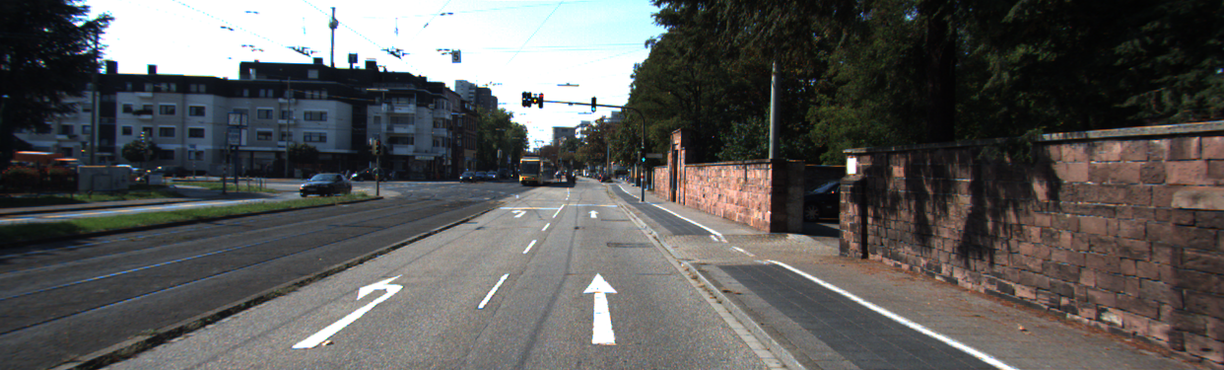

In [183]:
img

In [184]:
img_a = np.array(img)

In [239]:
mask = Image.open('mask_eigen.png')

In [243]:
mask_a = np.array(mask)

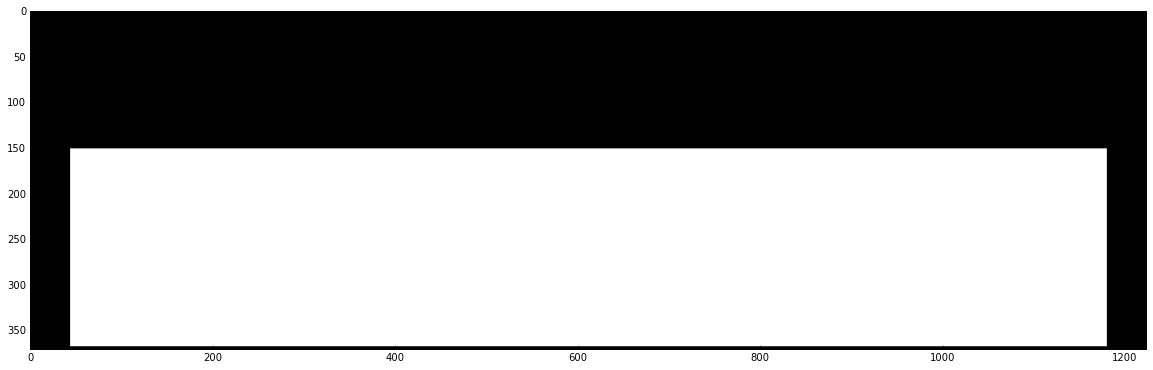

In [242]:
plt.figure(figsize=(20,10))
plt.imshow(mask)
plt.show()

In [273]:
np.all(~mask_a[:,43])

True

In [255]:
16*9

144

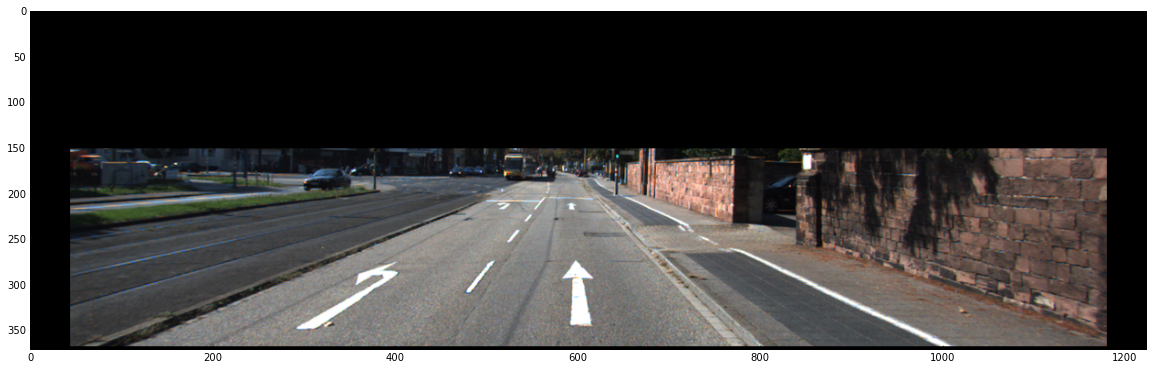

In [224]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.bitwise_and(img_a,img_a,mask = mask_a.astype(np.uint8)))
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.bitwise_and(img_a,img_a,mask = mask_a.astype(np.uint8)))
plt.show()